In [170]:
# Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, find_peaks
import glob

In [171]:
# For plotting pandas dataframes
def plot_df(df):
    # Plotting each column with row number as x-axis
    df.plot()

    # Adding labels and title
    plt.xlabel('Row Number')
    plt.ylabel('Values')
    plt.title('Pandas DataFrame Plot')
    plt.show()

def plot_ndarray(arr):
    plt.plot(arr)
    plt.xlabel('Row Number')
    plt.ylabel('Values')
    plt.title('Numpy NDArray Plot')
    plt.show()

In [172]:
# Global variables

# 2D Array, 137 features per row
all_features = np.empty((0, 137))
# 1D array, 1 number per row
all_answers = list()
# List of every file name in RawData
file_names = glob.glob("RawData" + '/*.txt')

In [173]:
def calculate_autocorrelation(data):
    autocorr_x = np.correlate(data[0], data[0], mode='full')[len(data[0])-1:]
    autocorr_y = np.correlate(data[1], data[1], mode='full')[len(data[1])-1:]
    autocorr_z = np.correlate(data[2], data[2], mode='full')[len(data[2])-1:]
    return autocorr_x, autocorr_y, autocorr_z

# Find peaks and extract required information
def extract_peak_info(autocorr):
    peaks, properties = find_peaks(autocorr)
    
    if len(peaks) > 1:
        main_peak_height = autocorr[peaks[0]]
        second_peak_height = autocorr[peaks[1]]
        second_peak_position = peaks[1]
    else:
        main_peak_height = autocorr[peaks[0]]
        second_peak_height = None
        second_peak_position = None
    
    return main_peak_height, second_peak_height, second_peak_position

In [174]:
def extractWindow(acc_data, gyro_data, activityNum: int):
    # Eventually a list of features 137 items long
    cur_features_row = np.array([])

    # Calculate mean for each direction in acc and gyro (6 total)
    mean_acc_x = acc_data[0].mean()
    mean_acc_y = acc_data[1].mean()
    mean_acc_z = acc_data[2].mean()
    mean_gyro_x = gyro_data[0].mean()
    mean_gyro_y = gyro_data[1].mean()
    mean_gyro_z = gyro_data[2].mean()

    # Calculate RMS for all (6 total numbers)
    rms_acc_x = np.sqrt(np.mean(acc_data[0]**2))
    rms_acc_y = np.sqrt(np.mean(acc_data[1]**2))
    rms_acc_z = np.sqrt(np.mean(acc_data[2]**2))
    rms_gyro_x = np.sqrt(np.mean(gyro_data[0]**2))
    rms_gyro_y = np.sqrt(np.mean(gyro_data[1]**2))
    rms_gyro_z = np.sqrt(np.mean(gyro_data[2]**2))

    '''I don't think I'm doing this right'''
    # Calculate autocorrelation for all. Height of 1st peak, height of 2nd peak, and position of 2nd peak (18 total numbers)
    autocorr_acc_x, autocorr_acc_y, autocorr_acc_z = calculate_autocorrelation(acc_data)
    acc_x_main_peak, acc_x_second_peak, acc_x_second_pos = extract_peak_info(autocorr_acc_x)
    acc_y_main_peak, acc_y_second_peak, acc_y_second_pos = extract_peak_info(autocorr_acc_y)
    acc_z_main_peak, acc_z_second_peak, acc_z_second_pos = extract_peak_info(autocorr_acc_z)
    plot_ndarray(autocorr_acc_x)
    print(autocorr_acc_x)
    print(acc_x_main_peak)

    autocorr_gyro_x, autocorr_gyro_y, autocorr_gyro_z = calculate_autocorrelation(gyro_data)
    gyro_x_main_peak, gyro_x_second_peak, gyro_x_second_pos = extract_peak_info(autocorr_gyro_x)
    gyro_y_main_peak, gyro_y_second_peak, gyro_y_second_pos = extract_peak_info(autocorr_gyro_y)
    gyro_z_main_peak, gyro_z_second_peak, gyro_z_second_pos = extract_peak_info(autocorr_gyro_z)

    # Spectral peaks (72)


    # Spectral power (30)


    # Resultant acceleration (1)


    # Resultant gyro (1)


    # Angle btwn resultant acc and each acc input (3)



    

    # all_features = np.vstack(all_features, cur_features_row)
    # all_answers.append(activityNum)


In [175]:
'''These are for noise reduction'''
# Function to apply median filter
def apply_median_filter(data, window_size):
    return data.rolling(window=window_size, center=True, min_periods=1).median()

# Function to design a low-pass Butterworth filter
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Function to apply the Butterworth filter
def apply_low_butter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order)
    y = filtfilt(b, a, data, axis=0)
    return y

'''This is for getting body acc component from total acc'''
# Define a function to create a high-pass Butterworth filter
def butter_highpass(cutoff, fs, order):
    nyquist = 0.5 * fs  # Nyquist frequency is half the sampling rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Define a function to apply the high-pass filter to data
def apply_high_butter(data, cutoff, fs, order):
    b, a = butter_highpass(cutoff, fs, order)
    y = filtfilt(b, a, data, axis=0)
    return y

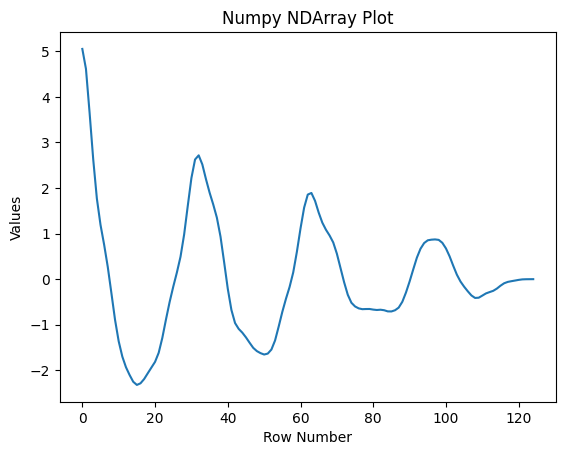

[ 5.05347871e+00  4.61482306e+00  3.65100827e+00  2.62611735e+00
  1.76862097e+00  1.19221341e+00  7.54633306e-01  2.66516307e-01
 -3.09552037e-01 -8.94995783e-01 -1.36447333e+00 -1.70066957e+00
 -1.93407256e+00 -2.10469138e+00 -2.25361049e+00 -2.32282958e+00
 -2.28728524e+00 -2.19375288e+00 -2.06644620e+00 -1.94115235e+00
 -1.81662744e+00 -1.61750371e+00 -1.29011357e+00 -8.87487333e-01
 -5.05679201e-01 -1.67940457e-01  1.44043531e-01  4.90659419e-01
  9.80012364e-01  1.60938933e+00  2.21896951e+00  2.62563775e+00
  2.71729095e+00  2.51776406e+00  2.19553964e+00  1.89874717e+00
  1.63884511e+00  1.34964420e+00  9.33779595e-01  3.70131099e-01
 -2.11595116e-01 -6.76988290e-01 -9.64149825e-01 -1.09254934e+00
 -1.17534348e+00 -1.27910305e+00 -1.39664996e+00 -1.50908149e+00
 -1.58038182e+00 -1.62504481e+00 -1.65548564e+00 -1.63498090e+00
 -1.54601526e+00 -1.34750219e+00 -1.04157167e+00 -7.18414592e-01
 -4.31574895e-01 -1.71409617e-01  1.47771363e-01  5.97673973e-01
  1.11127189e+00  1.57019

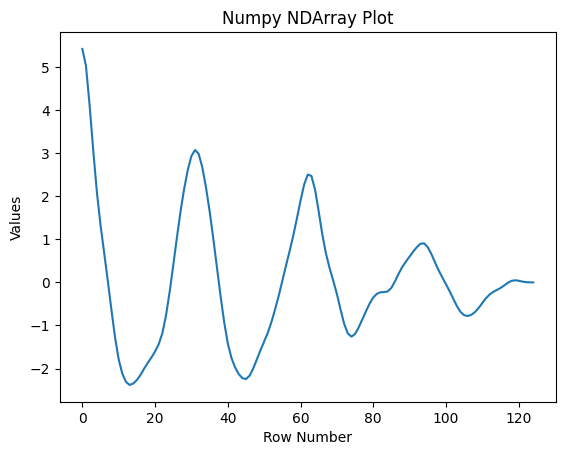

[ 5.41731305e+00  5.02541178e+00  4.11374141e+00  3.06318469e+00
  2.09625254e+00  1.33204955e+00  6.89739006e-01  4.02212364e-02
 -6.34785296e-01 -1.27740915e+00 -1.78703452e+00 -2.11869913e+00
 -2.30851743e+00 -2.37922508e+00 -2.34759614e+00 -2.26532001e+00
 -2.14786166e+00 -2.00100263e+00 -1.86812743e+00 -1.74347234e+00
 -1.60266431e+00 -1.43638680e+00 -1.18188976e+00 -7.74170999e-01
 -2.27958058e-01  3.93078190e-01  1.03398956e+00  1.64111300e+00
  2.16939918e+00  2.60874493e+00  2.93176989e+00  3.07236414e+00
  2.97991490e+00  2.66893670e+00  2.20967069e+00  1.65555335e+00
  1.02896782e+00  3.60966393e-01 -3.04725920e-01 -9.17678866e-01
 -1.41328574e+00 -1.75127625e+00 -1.97188093e+00 -2.12685312e+00
 -2.22090330e+00 -2.24301149e+00 -2.16558225e+00 -1.99707323e+00
 -1.78804210e+00 -1.57103647e+00 -1.37244223e+00 -1.17170085e+00
 -9.20889637e-01 -6.29364441e-01 -3.12257233e-01  3.42445838e-02
  3.85792677e-01  7.24262209e-01  1.08194329e+00  1.48045040e+00
  1.89310448e+00  2.26896

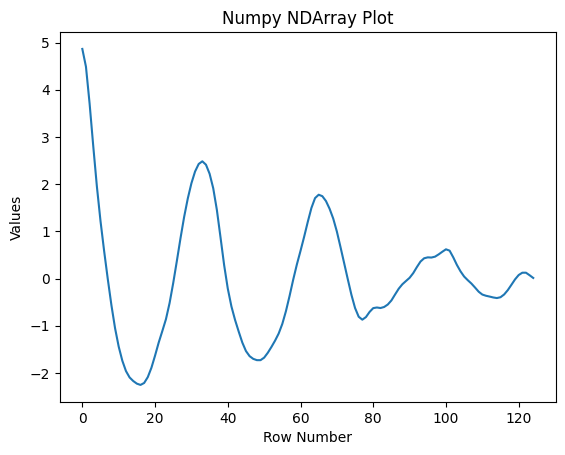

[ 4.86397539  4.4865371   3.70789162  2.80949455  1.95280231  1.21755431
  0.58040371 -0.01088424 -0.56480783 -1.05191902 -1.44212943 -1.74185268
 -1.96093787 -2.09633323 -2.17203392 -2.22786146 -2.25472106 -2.21348746
 -2.08985871 -1.8915946  -1.63420189 -1.35808021 -1.1133408  -0.86084015
 -0.51888439 -0.09402548  0.37306341  0.85374125  1.30454655  1.69386174
  2.01724778  2.26614176  2.42616674  2.48282245  2.41134957  2.21953658
  1.91166643  1.45328763  0.87321649  0.28372423 -0.21315139 -0.59097493
 -0.87704194 -1.12372835 -1.35730826 -1.53725084 -1.64505124 -1.70253316
 -1.73006327 -1.73040898 -1.67697614 -1.57437077 -1.45097452 -1.31710227
 -1.16515317 -0.96115474 -0.68972625 -0.36714831 -0.02183226  0.29758166
  0.58469563  0.88424276  1.19975387  1.49465193  1.70337065  1.77501718
  1.74411453  1.64109279  1.47732847  1.26926849  0.99472833  0.66557192
  0.32657341 -0.01390946 -0.34502203 -0.6248943  -0.81012958 -0.8724749
 -0.81695779 -0.70756847 -0.62738358 -0.61427591 -0.

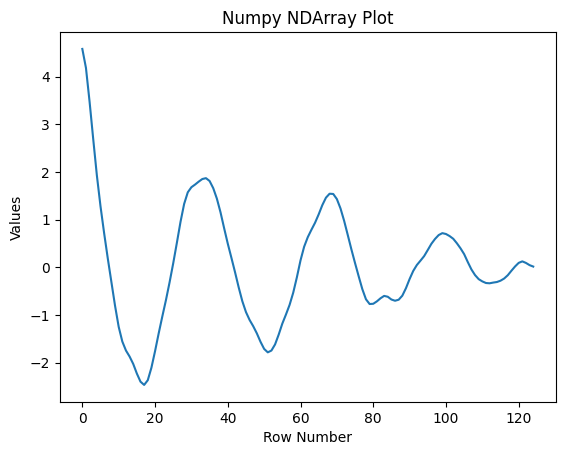

[ 4.5839336   4.18452472  3.47290003  2.68926741  1.92943778  1.28105186
  0.71590985  0.18777747 -0.31064867 -0.80730341 -1.24837948 -1.55771133
 -1.74595096 -1.87215485 -2.02766973 -2.22981987 -2.39969627 -2.46778393
 -2.36914888 -2.10678334 -1.7595148  -1.38562587 -1.03010748 -0.6858598
 -0.31273139  0.08690641  0.51467253  0.95360123  1.33106659  1.5745168
  1.68181368  1.73704059  1.79847077  1.85349708  1.87174424  1.8120476
  1.66166006  1.44240085  1.15562813  0.82073781  0.49690624  0.19979436
 -0.1033349  -0.4199569  -0.71041387 -0.93852763 -1.10434113 -1.23588167
 -1.386708   -1.56229907 -1.71212148 -1.78418054 -1.74643607 -1.61821407
 -1.41185417 -1.1808581  -0.98996475 -0.78747079 -0.53120401 -0.20962526
  0.14526887  0.43275845  0.63318106  0.78812868  0.93581667  1.11223152
  1.30582495  1.46237319  1.54522969  1.53980108  1.43259746  1.23591976
  0.9755974   0.67752851  0.37540524  0.08874623 -0.18869031 -0.45727933
 -0.6700724  -0.76977319 -0.76485155 -0.71443528 -0.64

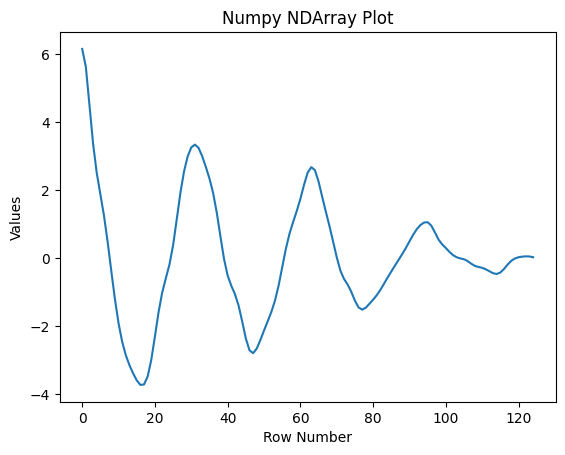

[ 6.16046106  5.63293815  4.50477275  3.36237619  2.50710776  1.8758094
  1.24096641  0.47404599 -0.38094405 -1.20986897 -1.92226441 -2.46945865
 -2.86398163 -3.15716793 -3.39599115 -3.60233491 -3.73722251 -3.72441992
 -3.48886738 -2.99579365 -2.30886148 -1.59383066 -1.01609713 -0.59511196
 -0.18885289  0.38032935  1.13912232  1.9173251   2.54874223  2.99381152
  3.25901778  3.34184745  3.2451304   3.00007553  2.68350518  2.34202787
  1.91870386  1.343302    0.64572145 -0.02634842 -0.51590888 -0.8156401
 -1.06062949 -1.39643274 -1.86714599 -2.36756747 -2.7159418  -2.8023881
 -2.66528584 -2.41433547 -2.13372314 -1.86546388 -1.59256025 -1.25764976
 -0.81584683 -0.27518781  0.26826805  0.71201259  1.06178878  1.38527584
  1.74350673  2.15522886  2.51475519  2.67803824  2.58801637  2.25466326
  1.801857    1.36634184  0.9408372   0.48721338  0.02402424 -0.369613
 -0.61595311 -0.78075504 -0.99472903 -1.25555423 -1.45442248 -1.51992538
 -1.46139753 -1.34557223 -1.22578071 -1.09493925 -0.9362

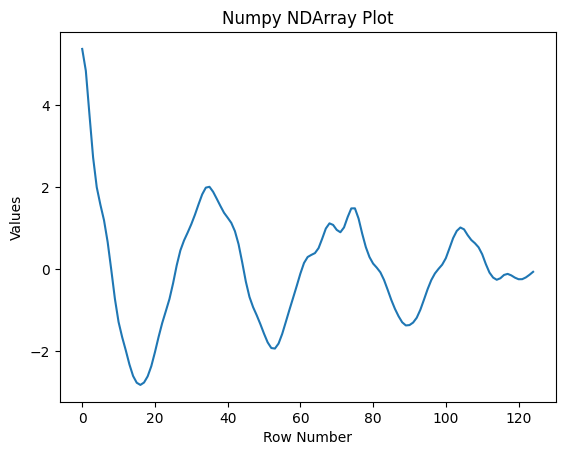

[ 5.37077588e+00  4.83612147e+00  3.76427312e+00  2.72086034e+00
  1.99504421e+00  1.56947881e+00  1.18844298e+00  6.57711346e-01
 -2.34051336e-02 -7.32014908e-01 -1.29357203e+00 -1.66704488e+00
 -1.99015361e+00 -2.33342246e+00 -2.61231089e+00 -2.77636781e+00
 -2.82962392e+00 -2.77149426e+00 -2.62092899e+00 -2.37322056e+00
 -2.03266760e+00 -1.66114535e+00 -1.31991271e+00 -1.02833709e+00
 -7.31560214e-01 -3.46254385e-01  9.24319805e-02  4.53776901e-01
  6.95621505e-01  8.88107887e-01  1.09203907e+00  1.32311118e+00
  1.57858751e+00  1.82142831e+00  1.98556570e+00  2.00565546e+00
  1.88424116e+00  1.71394040e+00  1.53894059e+00  1.37277705e+00
  1.25176214e+00  1.12566331e+00  9.22840530e-01  6.05024330e-01
  1.62945213e-01 -3.07689716e-01 -6.81762036e-01 -9.32124787e-01
 -1.13085867e+00 -1.34696665e+00 -1.57900426e+00 -1.79072802e+00
 -1.92871808e+00 -1.94219253e+00 -1.81986782e+00 -1.58495073e+00
 -1.29082546e+00 -9.92834688e-01 -7.04449585e-01 -4.12656368e-01
 -1.12292067e-01  1.46534

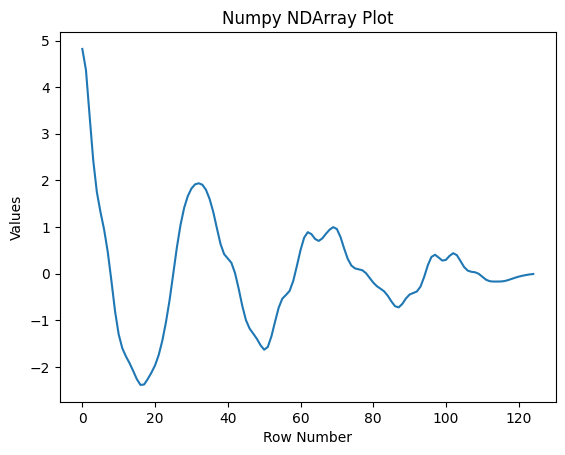

[ 4.82045453e+00  4.36795038e+00  3.38769054e+00  2.43118832e+00
  1.74846432e+00  1.31896497e+00  9.42113196e-01  4.63382088e-01
 -1.53407919e-01 -8.06000199e-01 -1.30398728e+00 -1.60108762e+00
 -1.77656974e+00 -1.92178837e+00 -2.08977538e+00 -2.26424734e+00
 -2.38703370e+00 -2.37789983e+00 -2.25893776e+00 -2.12421325e+00
 -1.96704480e+00 -1.74601580e+00 -1.43826592e+00 -1.04089933e+00
 -5.65393261e-01 -6.49087903e-03  5.61696552e-01  1.04286061e+00
  1.41110033e+00  1.66177186e+00  1.82435028e+00  1.91513183e+00
  1.93817324e+00  1.90799473e+00  1.79883500e+00  1.60270429e+00
  1.32583585e+00  9.76514859e-01  6.37826944e-01  4.17671589e-01
  3.25846951e-01  2.31510359e-01  1.07681816e-02 -3.24049514e-01
 -6.94268444e-01 -9.98064602e-01 -1.17764671e+00 -1.28644641e+00
 -1.39775093e+00 -1.53450791e+00 -1.63136365e+00 -1.57365262e+00
 -1.34612443e+00 -1.03108481e+00 -7.29325389e-01 -5.36008590e-01
 -4.57255321e-01 -3.69999029e-01 -1.57392594e-01  1.64122050e-01
  5.03091446e-01  7.71722

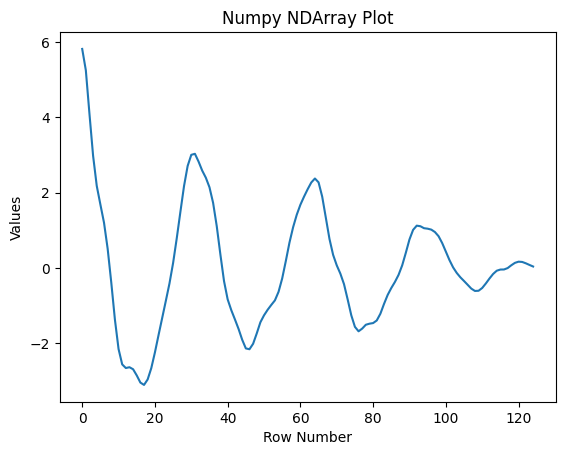

[ 5.82066974e+00  5.25350462e+00  4.09355303e+00  2.97957290e+00
  2.18299978e+00  1.68851981e+00  1.20387928e+00  5.13981061e-01
 -3.89314584e-01 -1.37306011e+00 -2.15185552e+00 -2.55960403e+00
 -2.65591924e+00 -2.63486067e+00 -2.68866190e+00 -2.85226798e+00
 -3.04252504e+00 -3.10489047e+00 -2.95965430e+00 -2.65886609e+00
 -2.24099037e+00 -1.77859315e+00 -1.32526644e+00 -8.70925192e-01
 -4.09861011e-01  1.35181191e-01  7.89341806e-01  1.48964448e+00
  2.17618897e+00  2.71286339e+00  3.00727875e+00  3.03432390e+00
  2.82796645e+00  2.58845085e+00  2.39964660e+00  2.14571440e+00
  1.73131041e+00  1.11332213e+00  3.60758315e-01 -3.45686119e-01
 -8.31408520e-01 -1.11885229e+00 -1.36425992e+00 -1.61766552e+00
 -1.90473610e+00 -2.13480125e+00 -2.15712176e+00 -2.01151322e+00
 -1.73722713e+00 -1.44115596e+00 -1.25604787e+00 -1.10800648e+00
 -9.79496236e-01 -8.58237786e-01 -6.30979903e-01 -2.75387723e-01
  1.88357692e-01  6.76041846e-01  1.08385859e+00  1.41531728e+00
  1.68080364e+00  1.89556

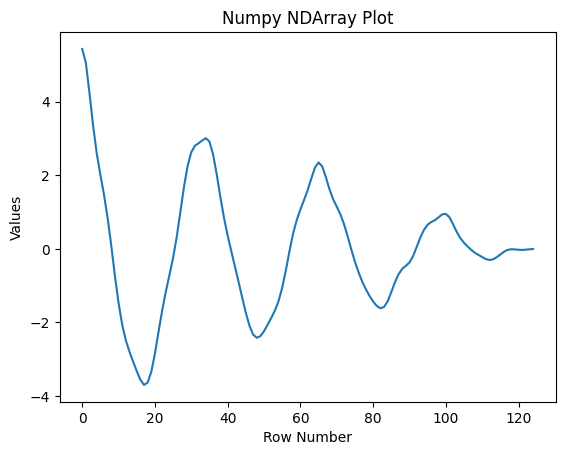

[ 5.43316578e+00  5.05999574e+00  4.23324020e+00  3.34754332e+00
  2.59119715e+00  2.01021421e+00  1.46677351e+00  8.33219116e-01
  8.10942521e-02 -7.36092143e-01 -1.47477814e+00 -2.06158747e+00
 -2.48960582e+00 -2.79563314e+00 -3.06527838e+00 -3.32420141e+00
 -3.55959643e+00 -3.69973875e+00 -3.63558032e+00 -3.34118484e+00
 -2.84750596e+00 -2.25132897e+00 -1.67444955e+00 -1.16270627e+00
 -7.09302187e-01 -2.45219186e-01  3.25741638e-01  1.00505942e+00
  1.68953630e+00  2.25508544e+00  2.62536045e+00  2.80095211e+00
  2.86949417e+00  2.94303571e+00  3.00812834e+00  2.91229825e+00
  2.56257623e+00  2.01982768e+00  1.40723606e+00  8.40570841e-01
  3.63615149e-01 -6.45017157e-02 -4.79691293e-01 -8.96647824e-01
 -1.32432804e+00 -1.73819380e+00 -2.09038259e+00 -2.32803911e+00
 -2.41817846e+00 -2.37422411e+00 -2.23874738e+00 -2.06090995e+00
 -1.87543018e+00 -1.67751320e+00 -1.42013716e+00 -1.05767983e+00
 -5.88982592e-01 -6.52713556e-02  4.13981762e-01  7.83142789e-01
  1.06911514e+00  1.32358

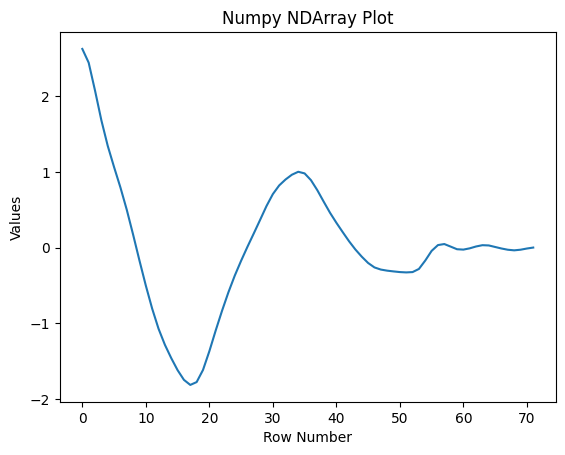

[ 2.62863014  2.4470175   2.07799581  1.68486624  1.34764846  1.06620701
  0.79714618  0.50179254  0.17268215 -0.16980295 -0.50026933 -0.80522213
 -1.0700586  -1.28228093 -1.458676   -1.61779117 -1.74623795 -1.81307184
 -1.77555    -1.61552656 -1.36820735 -1.09371402 -0.83265499 -0.58925023
 -0.36887683 -0.172171    0.01288286  0.18983523  0.36985051  0.55161819
  0.70937931  0.82431172  0.90268978  0.96567372  1.00455085  0.98316189
  0.89391965  0.76148353  0.61051117  0.46302632  0.33097663  0.20691301
  0.08604029 -0.02315883 -0.11769607 -0.20107705 -0.25982855 -0.28809354
 -0.30253579 -0.31249571 -0.32135718 -0.32570576 -0.32146343 -0.28000124
 -0.16889023 -0.04125724  0.03565983  0.04927644  0.01525999 -0.01936912
 -0.02432666 -0.00742285  0.01708325  0.03410029  0.03075163  0.01052756
 -0.00963689 -0.0260731  -0.03390048 -0.02571859 -0.01003244  0.00271738]
1.0045508537330923


In [176]:
# For handling raw data
def extractAllFeatures(label: str):
    splitted = label.split()
    experimentNum, activityNum, start, end = int(splitted[0]), int(splitted[2]), int(splitted[3]), int(splitted[4])

    acc_file_name = file_names[experimentNum-1]
    gyro_file_name = file_names[experimentNum-1+61]

    # Reading acc and gyro in data for this label range
    acc_data = pd.read_csv(acc_file_name, sep=' ', header=None, skiprows=start, nrows=end-start)
    gyro_data = pd.read_csv(gyro_file_name, sep=' ', header=None, skiprows=start, nrows=end-start)

    ''' I'm not too sure how these filters work but I hope they do'''
    # Apply median filter to each axis of accelerometer and gyroscope data (for noise reduction)
    WINDOW_SIZE = 3
    acc_data_filtered = acc_data.apply(apply_median_filter, window_size=WINDOW_SIZE)
    gyro_data_filtered = gyro_data.apply(apply_median_filter, window_size=WINDOW_SIZE)
    
    # Apply low-pass Butterworth filter to each axis of accelerometer and gyroscope data (for noise reduction)
    FS = 50                     # Sampling frequency in Hz (you mentioned 50Hz)
    CUTOFF_LOW_PASS = 20        # Desired cutoff frequency of the filter, Hz
    ORDER = 3                   # Order of the Butterworth filter
    acc_data_filtered = acc_data_filtered.apply(lambda col: apply_low_butter(col, CUTOFF_LOW_PASS, FS, ORDER))
    gyro_data_filtered = gyro_data_filtered.apply(lambda col: apply_low_butter(col, CUTOFF_LOW_PASS, FS, ORDER))    

    # Apply high-pass Butterworth filter to acc to get body component
    CUTOFF_HIGH_PASS = 0.5
    acc_data_filtered = acc_data_filtered.apply(lambda col: apply_high_butter(col, CUTOFF_HIGH_PASS, FS, ORDER))

    # 2.5sec windows * 50 samples per sec = 125 samples per window
    # 50% overlap means we go up by 62 for every new window
    # end-62 is used to skip the last half window that gets added
    length = end-start
    i = 0
    while i < length-62:
        trueEnd = min(i+125, length)
        extractWindow(acc_data_filtered[i: trueEnd], gyro_data_filtered[i: trueEnd], activityNum)
        i += 62


'''For testing'''
# extractAllFeatures('1 1 5 250 1232')
# extractAllFeatures('1 1 7 1233 1392')
# extractAllFeatures('1 1 4 1393 2194')
# extractAllFeatures('1 1 1 7496 8078')
extractAllFeatures('1 1 2 14069 14699')
# extractAllFeatures('1 1 3 14869 15492')

In [ ]:
# Main function
def main():
    # Grab the labels.txt file telling you what each data section means
    labels_file = open('labels.txt') 
    labels_list = labels_file.readlines()

    # For each section: 
        # i. Load that section's respective data
        # ii. For each window in that section:
            # a. Apply noise filters on the window
            # b. Compute features from the window
            # c. Store those feature values in an array
    for label in labels_list:
        extractAllFeatures(label)
    
    # Take all_features and answers, split into test and train, and finally write to .txt files

if __name__ == "__main__":
    main()